# Machine Learning II Project - Customer Segmentation


Group 17
- Joel Mendes - 20221825
- Lourenço Martins - 20222043
- Margarida Sardinha - 20221959

This project's goal is to segment a fictional retail company's customers into clusters, based on their demographic and purchasing data, and then create targeted promotions for each cluster detected.

This jupyter noteboook includes all functions and code that is required for our clustering solution, and that is the basis for the coupons and promotions created.

## Importing data and libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!cp -r "/content/drive/MyDrive/Colab Notebooks/Machine Learning II/Project/py_files" /content/py_files
!cp -r "/content/drive/MyDrive/Colab Notebooks/Machine Learning II/Project/data" /content/data

In [6]:
pip install umap-learn
pip install pyECLAT

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 6.7 MB/s eta 0:00:00


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, MeanShift
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from scipy.cluster.hierarchy import dendrogram, linkage
from shapely.geometry import Point
import geopandas as gpd
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

from py_files.preprocessing import *
from py_files.modeling import *
from py_files.ploting import *
from py_files.initial_visualizations import *
from py_files.t_SNE import *
from py_files.UMAP import *
from py_files.feature_selection import *

In [8]:
cust_basket = pd.read_csv('data/customer_basket.csv')
cust_info = pd.read_csv('data/customer_info.csv', index_col=0)
product_mapping = pd.read_excel('data/product_mapping.xlsx')

## Exploratory Data Analysis

The first step of any ML project is to clean and visualize the data one is working with. This, in our case, included creating variables and removing unwanted ones, scaling all numerical variables, and removing outliers, both random and those that form clusters a priori.

In [21]:
# Initial visualizations
display(cust_info.head())
display(cust_info.info())
display(cust_info.describe())
display(cust_info.describe(include=object))

display(cust_basket.head())
display(cust_basket.info())
display(cust_basket.describe())
display(cust_basket.describe(include=object))

product_mapping

,customer_id,customer_name,customer_gender,customer_birthdate,kids_home,teens_home,number_complaints,distinct_stores_visited,lifetime_spend_groceries,lifetime_spend_electronics,...,lifetime_spend_fish,lifetime_spend_hygiene,lifetime_spend_videogames,lifetime_spend_petfood,lifetime_total_distinct_products,percentage_of_products_bought_promotion,year_first_transaction,loyalty_card_number,latitude,longitude
0,39634,David Frink,male,05/15/1964 10:34 PM,1.0,1.0,1.0,2.0,18306.0,7106.0,...,4056.0,2174.0,3946.0,2514.0,32.0,0.072206,2010.0,NaN,38.735637,-9.149071
1,43460,Belinda Terry,female,03/26/1988 11:06 PM,1.0,0.0,1.0,2.0,5015.0,1334.0,...,1925.0,2115.0,1028.0,1987.0,2566.0,0.206227,2014.0,NaN,38.762702,-9.160802
2,23937,Evelyn Calico,female,04/13/1969 06:07 PM,0.0,1.0,1.0,3.0,3097.0,4073.0,...,2347.0,1306.0,1504.0,2018.0,1282.0,0.136168,2009.0,951127.0,38.717431,-9.165105
3,2431,Ora Boggess,female,06/15/1941 03:26 AM,0.0,0.0,0.0,1.0,10825.0,207.0,...,151.0,53.0,0.0,4135.0,70.0,0.215852,2007.0,958680.0,38.782169,-9.150318
4,10090,Lonnie Hopson,male,12/18/2001 03:03 AM,0.0,0.0,0.0,1.0,697.0,570.0,...,172.0,587.0,223.0,64.0,4.0,0.181023,2024.0,977059.0,38.770397,-9.177024


<class 'pandas.core.frame.DataFrame'>
Index: 43631 entries, 0 to 43630
Data columns (total 25 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   customer_id                              43631 non-null  int64  
 1   customer_name                            43631 non-null  object 
 2   customer_gender                          43631 non-null  object 
 3   customer_birthdate                       43631 non-null  object 
 4   kids_home                                43107 non-null  float64
 5   teens_home                               42610 non-null  float64
 6   number_complaints                        42977 non-null  float64
 7   distinct_stores_visited                  42322 non-null  float64
 8   lifetime_spend_groceries                 43631 non-null  float64
 9   lifetime_spend_electronics               43631 non-null  float64
 10  typical_hour                             41886 non-

None

,customer_id,kids_home,teens_home,number_complaints,distinct_stores_visited,lifetime_spend_groceries,lifetime_spend_electronics,typical_hour,lifetime_spend_vegetables,lifetime_spend_nonalcohol_drinks,...,lifetime_spend_fish,lifetime_spend_hygiene,lifetime_spend_videogames,lifetime_spend_petfood,lifetime_total_distinct_products,percentage_of_products_bought_promotion,year_first_transaction,loyalty_card_number,latitude,longitude
count,43631.000000,43107.000000,42610.000000,42977.000000,42322.000000,43631.000000,43631.000000,41886.000000,42758.000000,43631.000000,...,42322.000000,43631.000000,43631.000000,43631.000000,43631.000000,43631.000000,43631.000000,24654.000000,43631.000000,43631.000000
mean,24993.120877,1.081263,0.847829,0.705726,1.669959,5600.030047,2000.058468,13.520580,456.893938,443.636657,...,1471.423846,916.948408,990.334922,2023.225619,387.260182,0.229431,2011.342257,949808.661069,38.752266,-9.158591
std,14426.310863,1.239257,0.840397,0.624624,1.034825,4602.647746,3004.924537,4.558057,312.832282,210.313287,...,3910.163766,729.744050,1241.658577,2926.355387,411.436756,0.189242,4.656129,28894.251301,0.048629,0.036606
min,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,6.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-0.477986,1996.000000,900008.000000,38.690636,-9.418076
25%,12521.500000,0.000000,0.000000,0.000000,1.000000,2184.500000,218.000000,10.000000,227.000000,297.000000,...,187.000000,372.000000,204.000000,517.000000,97.000000,0.111704,2008.000000,924774.000000,38.732481,-9.175824
50%,24988.000000,1.000000,1.000000,1.000000,1.000000,4071.000000,574.000000,13.000000,387.000000,419.000000,...,641.000000,668.000000,557.000000,874.000000,252.000000,0.205235,2011.000000,949681.000000,38.748887,-9.160152
75%,37484.500000,1.000000,1.000000,1.000000,2.000000,6605.500000,2565.500000,17.000000,584.000000,560.000000,...,1570.000000,1437.000000,1111.000000,2217.000000,537.000000,0.310884,2014.000000,975117.250000,38.764504,-9.139240
max,50000.000000,9.000000,6.000000,9.000000,8.000000,26552.000000,21273.000000,24.000000,2112.000000,2224.000000,...,50381.000000,3487.000000,5389.000000,19596.000000,3544.000000,1.196858,2024.000000,999996.000000,39.357600,-9.055377


,customer_name,customer_gender,customer_birthdate
count,43631,43631,43631
unique,42351,2,43594
top,James Brown,female,08/13/1962 08:48 PM
freq,10,21910,2


,invoice_id,list_of_goods,customer_id
0,7448187,"['olive oil', 'yogurt cake', 'grated cheese', ...",43134
1,3167314,"['babies food', 'shower gel', 'rice', 'black b...",43134
2,10199712,"['babies food', 'barbecue sauce', 'olive oil',...",43134
3,12179179,"['babies food', 'milk', 'rice', 'yogurt cake',...",43134
4,8292388,"['napkins', 'cookies', 'razor', 'cooking oil',...",43134


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89952 entries, 0 to 89951
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   invoice_id     89952 non-null  int64 
 1   list_of_goods  89952 non-null  object
 2   customer_id    89952 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 2.1+ MB


None

,invoice_id,customer_id
count,8.995200e+04,89952.000000
mean,6.126259e+06,21855.193915
std,3.527265e+06,12610.661213
min,2.006600e+04,1.000000
25%,3.085110e+06,10814.000000
50%,6.133909e+06,21904.000000
75%,9.185876e+06,32771.000000
max,1.224224e+07,43631.000000


,list_of_goods
count,89952
unique,88767
top,"['babies food', 'cooking oil']"
freq,25


,product_name,category
0,champagne,alcohol_drinks
1,bramble,alcohol_drinks
2,white wine,alcohol_drinks
3,dessert wine,alcohol_drinks
4,french wine,alcohol_drinks
...,...,...
160,final fantasy XX,videogames
161,final fantasy XIX,videogames
162,final fantasy XXII,videogames
163,dog food,pet food


#### Inconsistencies found

In [9]:
# Variables with missing values
cust_info.isnull().sum()

customer_id                                    0
customer_name                                  0
customer_gender                                0
customer_birthdate                             0
kids_home                                    524
teens_home                                  1021
number_complaints                            654
distinct_stores_visited                     1309
lifetime_spend_groceries                       0
lifetime_spend_electronics                     0
typical_hour                                1745
lifetime_spend_vegetables                    873
lifetime_spend_nonalcohol_drinks               0
lifetime_spend_alcohol_drinks                  0
lifetime_spend_meat                            0
lifetime_spend_fish                         1309
lifetime_spend_hygiene                         0
lifetime_spend_videogames                      0
lifetime_spend_petfood                         0
lifetime_total_distinct_products               0
percentage_of_produc

In [10]:
# Other noteworthy details
# A percentage cannot be negative
cust_info['percentage_of_products_bought_promotion'].min()

-0.4779855680623625

### Preprocessing

In [11]:
# Preproc utils

from sklearn.preprocessing import RobustScaler
from sklearn.impute import KNNImputer

def scaling(df:pd.DataFrame, numeric_cols:list) -> pd.DataFrame:
  '''
  Scales the given numeric columns using Robust
  '''
  scaler = RobustScaler()
  df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
  return df

def convert_date_times(df:pd.DataFrame, columns:list) -> pd.DataFrame:
  '''
  Converts the given columns to datetime
  '''
  for col in columns:
    df[str(col)] = pd.to_datetime(df[str(col)])
  return df


def imputation(df:pd.DataFrame, colstoimpute:list) -> pd.DataFrame:
  '''
  Applies knnimputer to the given columns
  '''
  imputer = KNNImputer(n_neighbors=5)
  df[colstoimpute] = imputer.fit_transform(df[colstoimpute])
  return df

def extract_education(name:str) -> int:
  '''
  Maps strings found in names to their corresponding years of education
  Assuming none = 12 years of base education
  '''
  if 'Bsc.' in name:
      return 15
  elif 'Msc.' in name:
      return 17
  elif 'Phd.' in name:
      return 19
  else:
      return 12


In [41]:
from copy import deepcopy
def custinfo_feature_eng(df:pd.DataFrame) -> pd.DataFrame:
  '''
  Creates new variables and adds them to df
  To be applied to the original customer_info dataset
  '''
  cust_info = deepcopy(df)
  cust_info.index = cust_info.customer_id
  cust_info.drop('customer_id', axis=1, inplace=True)

  # Fixing the negative percentages in the percentage_bought_promotion column
  cust_info['percentage_of_products_bought_promotion'] = abs(cust_info['percentage_of_products_bought_promotion'])

  # Extract age from birthdate (considering today=08/06/2024)
  convert_date_times(cust_info, columns=['customer_birthdate'])
  cust_info['age'] = cust_info['customer_birthdate'].apply(lambda x: (pd.to_datetime('2024-06-08 11:06:17.747865') - x).days // 365)
  cust_info.drop('customer_birthdate', axis=1, inplace=True)

  # Turn gender into a boolean (True if female)
  cust_info['gender'] = cust_info['customer_gender'].apply(lambda gender: 1 if gender == 'female' else 0)
  cust_info.drop('customer_gender', axis=1, inplace=True)

  # Turn card number into a boolean (True if the person has a card)
  cust_info['loyalty_program'] = cust_info['loyalty_card_number'].notnull()
  cust_info.drop('loyalty_card_number', axis=1, inplace=True)

  # Apply the function created above to create a new 'Education' column
  cust_info['education'] = cust_info['customer_name'].apply(extract_education)

  # Create a column to check if the person is vegetarian
  cust_info['vegetarian'] = np.where((cust_info['lifetime_spend_fish'] == 0) & (cust_info['lifetime_spend_meat'] == 0), 1, 0)

  # Create a lifetime_total_spent column
  cust_info['lifetime_total_spent'] = cust_info[['lifetime_spend_groceries', 'lifetime_spend_electronics', 'lifetime_spend_vegetables',
                                  'lifetime_spend_nonalcohol_drinks', 'lifetime_spend_alcohol_drinks', 'lifetime_spend_meat',
                                  'lifetime_spend_fish', 'lifetime_spend_hygiene', 'lifetime_spend_videogames',
                                  'lifetime_spend_petfood', 'lifetime_total_distinct_products']].sum(axis=1)

  return cust_info

In [13]:
from copy import deepcopy

def scaling_imputation(df:pd.DataFrame) -> pd.DataFrame:
  '''
  Function that imputes missing values, scaling the data to do so
  '''
  cust_info = deepcopy(df)
  cust_info.index = cust_info.customer_id

  # Drop non-numeric columns for imputation
  numeric_cols = cust_info.select_dtypes(include=[np.number]).columns
  non_numeric_cols = cust_info.select_dtypes(exclude=[np.number]).columns

  # Scaling and imputation
  scaling(cust_info, numeric_cols)
  imputation(cust_info, numeric_cols)

  # Combine numeric and non-numeric columns back
  cust_info = pd.concat([cust_info[non_numeric_cols], cust_info[numeric_cols]], axis=1)
  cust_info.drop('customer_id', axis=1, inplace=True)

  return cust_info

In [27]:
def cust_basket_preproc(df):
    '''
    Function that applies preprocessing to the customer basket dataset
    '''
    cust_basket = deepcopy(df)
    # Convert purchases from strings to actual lists
    cust_basket['list_of_goods'] = cust_basket['list_of_goods'].apply(eval)

    cust_basket.index = cust_basket.invoice_id

    cust_basket.drop('invoice_id', axis=1, inplace=True)

    return cust_basket

In [25]:
from mlxtend.preprocessing import TransactionEncoder

def cust_basket_encoding(df):
  goods = df['list_of_goods'].to_list()

  te = TransactionEncoder()
  te_fit = te.fit(goods).transform(goods)
  encoded = pd.DataFrame(te_fit, columns=te.columns_)

  encoded_df = pd.concat([df.reset_index(drop=True), encoded], axis=1)
  encoded_df.index = df.index
  encoded_df.drop('list_of_goods', axis=1, inplace=True)

  return encoded_df

In [42]:
# Applying the preproc functions to customer_info
info_treated = custinfo_feature_eng(cust_info)
info_scaled = scaling_imputation(info_treated)

AttributeError: 'DataFrame' object has no attribute 'customer_id'

In [29]:
# Applying the preproc functions to customer_basket
basket_treated = cust_basket_preproc(cust_basket)
basket_encoded = cust_basket_encoding(basket_treated)

We end up with the following dataframes:

* *info_treated* - Unscaled, but with the new features, to be used in interpretation of clusters. The cluster labels will be added here.
* *info_scaled* - Scaled with Robust Scaler, with missing values imputed with KNN, to be used for modelling
* *basket_treated* - Cleaned up, to serve as reference if needed
* *basket_encoded* - With TransactionEncoded applied, to be used for association rules

### Visualizations

In [ ]:
'''plot_population(info_treated)'''

In [ ]:
plot_distributions_grid(info_treated, ['customer_name', 'age', 'gender', 'vegetarian'], figsize=(20, 15), bins=30)

In [ ]:
plot_variable_correlation(info_scaled, ['customer_name', 'education'])

### Feature Selection

Based on the results above, here we remove the unwanted features, those that were too highly correlated and thus worked as proxies for another.

In [30]:
def feature_selection(df: pd.DataFrame) -> pd.DataFrame:
    '''
    Function that removes unwanted variables from the dataset
    '''
    highly_correlated_vars = ['lifetime_spend_videogames', 'lifetime_spend_meat']
    for var in highly_correlated_vars:
        if var in df.columns:
            df.drop(var, axis=1, inplace=True)

    return df

In [31]:
info_scaled = feature_selection(info_scaled)

## Customer Segmentation

### Preparing the data

To apply to the clustering algorithms, only the variables relating to purchase history will be used.

The initial plan was to create 2 clustering solutions and merge them based on results, but due to time constraints, only the most relevant variables, the ones relating to purchase history, will be used. In future, the project could be expanded upon by utilizing the demographic variables as well.

In [47]:
def custinfo_separator(df: pd.DataFrame):
    '''
    Function that separates customer_info into variables for purchase history and for demographics
    '''
    purchaseHistoryVars = ['lifetime_spend_groceries', 'lifetime_spend_electronics', 'lifetime_spend_vegetables',
                           'lifetime_spend_nonalcohol_drinks', 'lifetime_spend_alcohol_drinks', 'lifetime_spend_meat',
                           'lifetime_spend_fish', 'lifetime_spend_hygiene', 'lifetime_spend_videogames',
                           'lifetime_spend_petfood', 'lifetime_total_distinct_products',
                           'percentage_products_bought_promotion', 'lifetime_total_spent']

    demographicVars = ['gender', 'education', 'kids_home', 'teens_home', 'age',
                       'latitude', 'longitude', 'year_first_transaction',
                       'number_complaints', 'typical_hour', 'distinct_stores_visited']

    # Initialize empty DataFrames
    purchaseHistorySolution = pd.DataFrame()
    demographicSolution = pd.DataFrame()

    # Add columns to purchaseHistorySolution if they exist in the input DataFrame
    for var in purchaseHistoryVars:
        if var in df.columns:
            purchaseHistorySolution[var] = df[var]

    # Add columns to demographicSolution if they exist in the input DataFrame
    for var in demographicVars:
        if var in df.columns:
            demographicSolution[var] = df[var]

    return purchaseHistorySolution, demographicSolution

In [48]:
modeldf_purchase, modeldf_demog = custinfo_separator(info_scaled)

### K-Means Clustering

In [34]:
# Checking the optimum number of clusters to look for
dispersion = create_dispersion_list(modeldf_purchase)
plot_elbow_graph(dispersion)

In [49]:
allocate_clusters_kmeans(info_treated, modeldf_purchase, n_clusters=7)

<Figure size 1400x800 with 0 Axes>

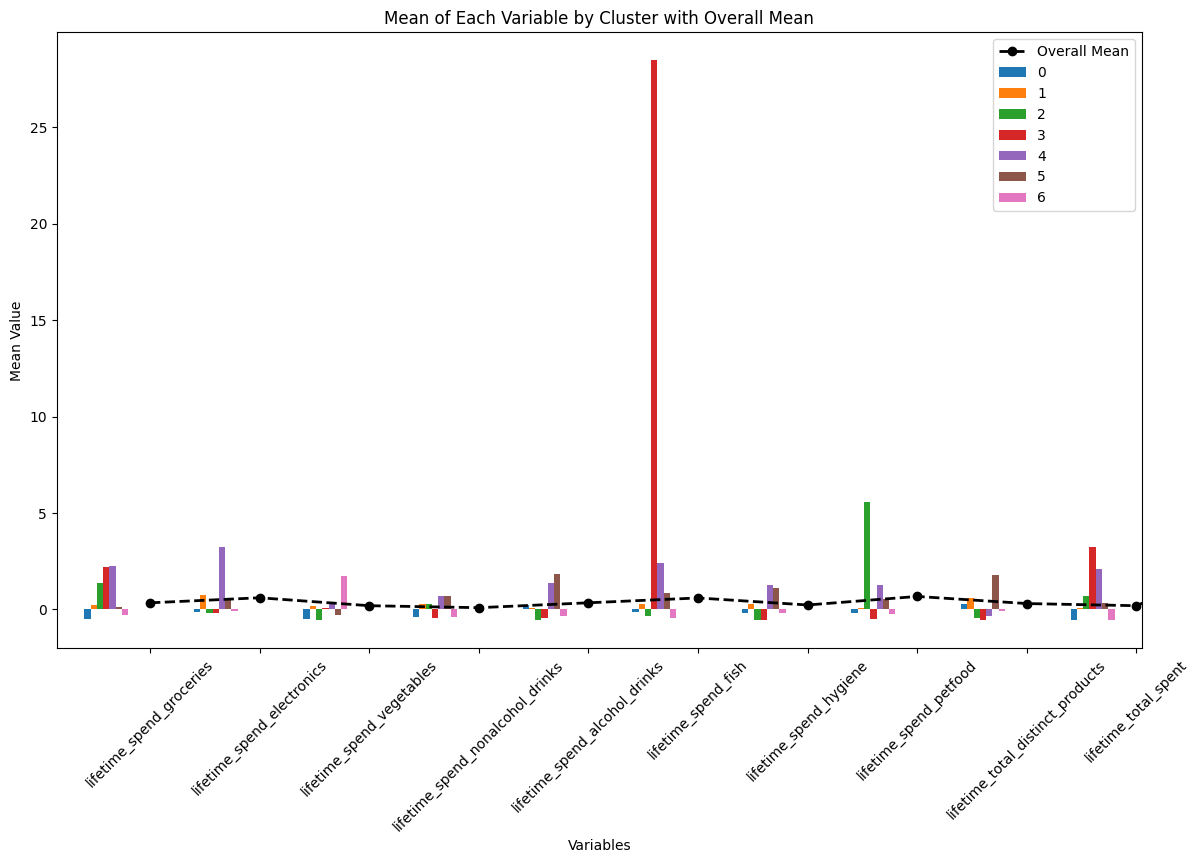

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Plotting cluster description using only the modelling variables
cluster_means = modeldf_purchase.groupby('cluster_kmeans').mean()
overall_mean = modeldf_purchase.mean()

overall_mean_df = overall_mean.to_frame().T
overall_mean_df.index = ['Overall Mean']
combined_means = pd.concat([cluster_means, overall_mean_df])

plt.figure(figsize=(14, 8))

# Plot each variable's mean for each cluster using clustered bar plots
ax = cluster_means.T.plot(kind='bar', width=0.4, position=1.5, ax=None, figsize=(14, 8))

# Plot the overall mean using a line plot on the same axes
overall_mean_df.T.plot(kind='line', marker='o', linestyle='--', color='black', linewidth=2, ax=ax, label='Overall Mean')

plt.title('Mean of Each Variable by Cluster with Overall Mean')
plt.xlabel('Variables')
plt.ylabel('Mean Value')
plt.legend()
plt.xticks(rotation=45)
plt.show()

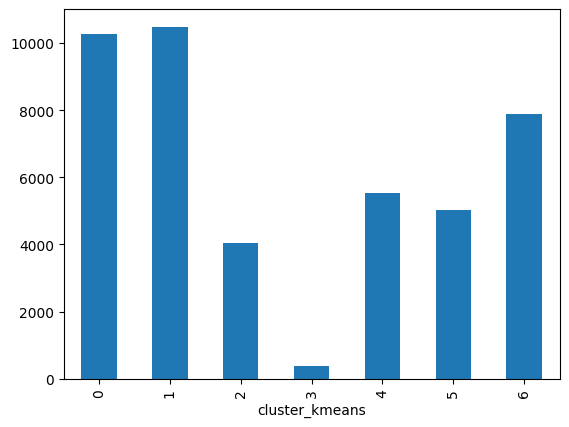

In [ ]:
# Comparing cluster sizes
modeldf_purchase.groupby(['cluster_kmeans']).size().plot(kind='bar')
plt.show()

### Hierarchical Clustering

In [ ]:
agg_clust = create_agg_clusters(modeldf_purchase)

KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots()
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(agg_clust, truncate_mode="level", p=50)
plt.show()

In [ ]:
allocate_clusters_aggclust(modeldf_purchase, modeldf_purchase, n_clusters=8)

In [ ]:
modeldf_purchase.groupby(['cluster_hierarchical']).mean()

In [ ]:
modeldf_purchase.mean()

In [ ]:
pd.DataFrame(
    confusion_matrix(sample_pp.cluster_kmeans, sample_pp.cluster_hierarchical),
    index = ['K-means {} Cluster'.format(i) for i in np.arange(0,8)],
    columns = ['Ward {} Cluster'.format(i) for i in np.arange(0,8)],
)

In [ ]:
modeldf_purchase.groupby(['cluster_hierarchical']).size().plot(kind='bar')
plt.show()

In [ ]:
eps_values = np.arange(0.1, 1.1, 0.1)
min_samples_values = range(2, 11)

# ITERATE CLUSTERS TO DEFINE THE BEST PARAMS

for min_samples_test in min_samples_values:
    for eps_test in eps_values:
        '''model = DBSCAN(eps=eps, min_samples=min_samples)
        model.fit_predict(data_preprocessed)'''
        pass

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

def plot_k_distance(X, k):
    nbrs = NearestNeighbors(n_neighbors=k).fit(X)
    distances, indices = nbrs.kneighbors(X)
    distances = np.sort(distances[:, k-1], axis=0)
    plt.plot(distances)
    plt.xlabel('Points sorted by distance')
    plt.ylabel(f'{k}-th Nearest Neighbor Distance')
    plt.title(f'k-distance Graph for k={k}')
    plt.show()

# Plot the k-distance graph
plot_k_distance(sample_pp_sc, k=4)

In [ ]:
from scipy.spatial import distance_matrix

# Calculate the distance matrix
dist_matrix = distance_matrix(sample_purchase, sample_pp_sc)

# Summary statistics of pairwise distances
print('Min distance:', np.min(dist_matrix))
print('Max distance:', np.max(dist_matrix))
print('Mean distance:', np.mean(dist_matrix))
print('Median distance:', np.median(dist_matrix))

### DBSCAN

In [ ]:
eps_range = np.arange(1, 2.5, 0.1)
min_samples_range = range(5, 13)

# Function to calculate and print cluster sizes and noise points
def print_cluster_info(labels):
    unique_labels, counts = np.unique(labels, return_counts=True)
    cluster_info = dict(zip(unique_labels, counts))

    noise_points = cluster_info.get(-1, 0)
    clusters = {k: v for k, v in cluster_info.items() if k != -1}

    return clusters, noise_points

# Grid search over the parameter ranges
for min_samples in min_samples_range:
    for eps_val in eps_range:
        model = DBSCAN(eps=eps_val, min_samples=min_samples)
        labels = model.fit_predict(sample_purchase)

        clusters, noise_points = print_cluster_info(labels)

        if noise_points <= 500:
            print(f'eps: {round(eps_val,2)}, min_samples: {min_samples}')
            print(f'Cluster sizes: {clusters}')
            print(f'Number of noise points: {noise_points}')
            print('-' * 40)

In [ ]:
allocate_clusters_dbscan(sample_pp, sample_pp_sc, eps=2.5, min_samples=8)

sample_pp.groupby(['cluster_dbscan']).mean()

In [ ]:
sample_pp.groupby(['cluster_dbscan']).size().plot(kind='bar')
plt.show()

### Meanshift

In [ ]:
from sklearn.cluster import estimate_bandwidth

estimate_bandwidth(sample_pp_sc, quantile=0.15)

In [ ]:
allocate_clusters_meanshift(sample_pp, sample_pp_sc, bandwidth=4)

In [ ]:
sample_pp.groupby(['cluster_meanshift']).mean()

In [ ]:
sample_pp.groupby(['cluster_meanshift']).size().plot(kind='bar')
plt.show()

### Segment Descriptions

In [ ]:
# t_SNE
apply_tsne(modeldf_purchase)

In [ ]:
import umap

def apply_umap(dataset):
  X_sample = dataset.iloc[:,1:]
  y_sample = dataset.iloc[:,0]

  umap_object = umap.UMAP(n_neighbors=15, min_dist=0.3, random_state=42)
  X_sample = X_sample.sort_index()

  umap_embedding = umap_object.fit_transform(X_sample)

  return(umap_embedding)

In [ ]:
def visualize_dimensionality_reduction(embed, dataset):
  '''
  by Miguel Nascimento
  '''
  df = pd.DataFrame(embed).set_index(dataset.index)
  df = df.merge(dataset['cluster_kmeans'], left_on=df.index, right_on=dataset.index, how='left').drop('key_0', axis=1).rename({0:'x1',1:'x2'}, axis=1).set_index(dataset.index)

  palette = sns.color_palette("tab10", len(df['cluster_kmeans'].unique()))

  # Create a dictionary mapping each unique cluster value to a color in the palette
  cluster_color_dict = dict(zip(df['cluster_kmeans'].unique(), palette))

  # Map cluster values to colors using the dictionary
  cluster_colors = df['cluster_kmeans'].map(cluster_color_dict)

  # Create a scatter plot with seaborn
  sns.scatterplot(data=df, x='x1', y='x2', hue='cluster_kmeans',
                  palette=cluster_color_dict, hue_order=sorted(df['cluster_kmeans'].unique()),
                  legend='full', edgecolor='none')

In [ ]:
# UMAP
#umap_embed = apply_umap(modeldf_purchase)
visualize_dimensionality_reduction(umap_embed, info_treated)

### Segment Comparison

## Association Rules

We know it would be best to divide the dataset into train and test, and evaluate how well the rules describe the entire population, but due to time constraints this was not possible for us to do. In a future project, this would be something to improve on.

In [37]:
from pyECLAT import ECLAT
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [61]:
# Joining the cluster labels onto the customer baskets and anonymizing
basket_rules_df = pd.merge(basket_encoded,
                           info_treated[['cluster_kmeans']],
                           how='inner', left_on='customer_id', right_index=True)
basket_rules_df.drop('customer_id', axis=1, inplace=True)

In [63]:
basket_rules_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 89952 entries, 7448187 to 8150061
Columns: 163 entries, airpods to cluster_kmeans
dtypes: bool(162), int32(1)
memory usage: 14.9 MB


In [65]:
# Separating the basket_rules_df dataframe into one per cluster
grouped = basket_rules_df.groupby('cluster_kmeans')

# cluster_dfs - dictionary of the form cluster label : Dataframe filtered for that cluster
cluster_dfs = {cluster: data.drop(columns='cluster_kmeans') for cluster, data in grouped}

In [88]:
frequent_itemsets_grocery = apriori(
    cluster_dfs[1], min_support=0.05, use_colnames=True
    )

print(frequent_itemsets_grocery.sort_values(by='support', ascending=False))

rules_grocery = association_rules(frequent_itemsets_grocery,
                                  metric="confidence",
                                  min_threshold=0.2)
rules_grocery.sort_values(by='lift', ascending=False)

      support                             itemsets
33   0.778878                             (shrimp)
13   0.553355                         (fresh tuna)
95   0.443344                 (fresh tuna, shrimp)
29   0.426843                             (salmon)
121  0.342134                     (salmon, shrimp)
..        ...                                  ...
105  0.050605                    (salmon, muffins)
40   0.050605                             (turkey)
80   0.050605              (french fries, seabass)
55   0.050605          (french fries, canned_tuna)
186  0.050605  (fresh tuna, salmon, trout, shrimp)

[187 rows x 2 columns]


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
326,"(fresh tuna, oil)","(salmon, shrimp)",0.114411,0.342134,0.057206,0.500000,1.461415,0.018062,1.315732,0.356522
330,(oil),"(fresh tuna, salmon, shrimp)",0.193619,0.206821,0.057206,0.295455,1.428554,0.017161,1.125803,0.372022
325,"(fresh tuna, salmon, shrimp)",(oil),0.206821,0.193619,0.057206,0.276596,1.428554,0.017161,1.114703,0.378214
329,"(fresh tuna, salmon)","(oil, shrimp)",0.255226,0.157316,0.057206,0.224138,1.424765,0.017055,1.086126,0.400295
328,"(oil, shrimp)","(fresh tuna, salmon)",0.157316,0.255226,0.057206,0.363636,1.424765,0.017055,1.170360,0.353786
...,...,...,...,...,...,...,...,...,...,...
58,(muffins),(fresh tuna),0.123212,0.553355,0.066007,0.535714,0.968120,-0.002174,0.962004,-0.036198
81,(muffins),(salmon),0.123212,0.426843,0.050605,0.410714,0.962215,-0.001987,0.972631,-0.042868
197,"(salmon, cooking oil)",(shrimp),0.086909,0.778878,0.064906,0.746835,0.958861,-0.002785,0.873432,-0.044879
39,(catfish),(trout),0.243124,0.222222,0.051705,0.212670,0.957014,-0.002322,0.987867,-0.056021


The higher the lift, the more specific the association rules are to the cluster at hand. To find better lift, we try lowering the minimum support

In [ ]:
train_data_rules = rules_grocery_iter_2[['antecedents','consequents','lift']]

In [ ]:
eclat_groceries = ECLAT(data=pd.DataFrame(train))

groceries_rules_indexes, groceries_rules_supports = eclat_groceries.fit(min_support=0.02,
                                           min_combination=2,
                                           max_combination=2)
rules_eclat_groceries = pd.DataFrame(
  list(groceries_rules_supports.values()),
  index=list(groceries_rules_supports.keys()),
  columns=['support']
)

rules_eclat_groceries.sort_values(by='support', ascending=False).head(10)